In [1]:
import os
import sys
import random
import math
import re
import time
import json

import skimage
import numpy as np
import tensorflow as tf
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as patches

# Root directory of the project
ROOT_DIR = os.path.abspath("Mask_RCNN")

# Import Mask RCNN
sys.path.append(ROOT_DIR)  # To find local version of the library
from mrcnn import utils
from mrcnn import visualize
from mrcnn.visualize import display_images
import mrcnn.model as modellib
from mrcnn.model import log
from mrcnn.config import Config

%matplotlib inline 

# Directory to save logs and trained model
MODEL_DIR = os.path.join(ROOT_DIR, "logs")

# Path to weights file for our model
LAST_TRAINED_MODEL_WEIGHTS = ''

Using TensorFlow backend.


In [2]:
class FoodConfig(Config):
    """Configuration for training on the toy  dataset.
    Derives from the base Config class and overrides some values.
    """
    # Give the configuration a recognizable name
    NAME = "food"

    # We use a GPU with 12GB memory, which can fit two images.
    # Adjust down if you use a smaller GPU.
    IMAGES_PER_GPU = 1

    # Number of classes (including background)
    NUM_CLASSES = 1 + 4  # Background + samosa + pizza + cupcake + omelette

    # Number of training steps per epoch
    STEPS_PER_EPOCH = 100

    # Skip detections with < 90% confidence
    DETECTION_MIN_CONFIDENCE = 0.9

In [3]:
config = FoodConfig()

DATASET_PATH = 'C:\College\Major Project\PROJECT\dataset'

In [4]:
def get_ax(rows=1, cols=1, size=8):
    """Return a Matplotlib Axes array to be used in
    all visualizations in the notebook. Provide a
    central point to control graph sizes.
    
    Adjust the size attribute to control how big to render images
    """
    _, ax = plt.subplots(rows, cols, figsize=(size*cols, size*rows))
    return ax

In [5]:
class FoodDataset(utils.Dataset):

    def load_food(self, dataset_dir, subset):
        """Load a subset of the Balloon dataset.
        dataset_dir: Root directory of the dataset.
        subset: Subset to load: train or val
        """
        # Add classes.
        self.add_class("food", 1, "samosa")
        self.add_class("food", 2, "pizza")
        self.add_class("food", 3, "cupcake")
        self.add_class("food", 4, "omelette")

        # Train or validation dataset?
        assert subset in ["train", "val"]
        dataset_dir = os.path.join(dataset_dir, subset)

        # We mostly care about the x and y coordinates of each region
        # Note: In VIA 2.0, regions was changed from a dict to a list.
        annotations = json.load(open(os.path.join(dataset_dir, "via_region_data.json")))
        annotations = list(annotations.values())  # don't need the dict keys

        # The VIA tool saves images in the JSON even if they don't have any
        # annotations. Skip unannotated images.
        annotations = [a for a in annotations if a['regions']]

        for a in annotations:
            # Get the x, y coordinaets of points of the polygons that make up
            # the outline of each object instance.
            # These are stores in the shape_attributes (see json format above).
            # The if condition is needed to support VIA versions 1.x and 2.x.
            if type(a['regions']) is dict:
                polygons = [r['shape_attributes'] for r in a['regions'].values()]
            else:
                polygons = [r['shape_attributes'] for r in a['regions']]
                
            if type(a['regions']) is dict:
                region_attributes = [r['region_attributes'] for r in a['regions'].values()]
            else:
                region_attributes = [r['region_attributes'] for r in a['regions']]

            num_ids=[]
            for item in region_attributes:
                try:
                    if item['food'] == 'samosa':
                        num_ids.append(1)
                    elif item['food'] =='pizza':
                        num_ids.append(2)
                    elif item['food'] == 'cupcake':
                        num_ids.append(3)
                    elif item['food'] == 'omelette':
                        num_ids.append(4)
                except:
                    pass

            # load_mask() needs the image size to convert polygons to masks.
            # Unfortunately, VIA doesn't include it in JSON, so we must read
            # the image. This is only managable since the dataset is tiny.
            image_path = os.path.join(dataset_dir, a['filename'])
            image = skimage.io.imread(image_path)
            height, width = image.shape[:2]

            self.add_image(
                "food",
                image_id=a['filename'],  # use file name as a unique image id
                path=image_path,
                width=width,
                height=height,
                polygons=polygons,
                num_ids=num_ids
            )

    def load_mask(self, image_id):
        """Generate instance masks for an image.
       Returns:
        masks: A bool array of shape [height, width, instance count] with
            one mask per instance.
        class_ids: a 1D array of class IDs of the instance masks.
        """
        image_info = self.image_info[image_id]

        # If not a food dataset image, delegate to parent class.
        if image_info["source"] != "food":
            return super(self.__class__, self).load_mask(image_id)

        # Convert polygons to a bitmap mask of shape
        # [height, width, instance_count]
        info = self.image_info[image_id]

        # Empty mask
        mask = np.zeros(
            [
                info["height"],
                info["width"],
                len(info["polygons"])
            ],
            dtype=np.uint8
        )

        for i, p in enumerate(info["polygons"]):
            # Get indexes of pixels inside the polygon and set them to 1
            x, y = skimage.draw.polygon(p['all_points_y'], p['all_points_x'])
            mask[x, y, i] = 1
            
        class_ids = image_info['num_ids']
        class_ids = np.reshape(class_ids, [mask.shape[-1]])

        # Return mask, and array of class IDs of each instance.
        return mask.astype(np.bool), class_ids

    def image_reference(self, image_id):
        """Return the path of the image."""
        info = self.image_info[image_id]
        if info["source"] == "food":
            return info["path"]
        else:
            super(self.__class__, self).image_reference(image_id)

In [6]:
FOOD_DIR = 'C:/College/Major Project/PROJECT/dataset'

# Load validation dataset
dataset = FoodDataset()
dataset.load_food(FOOD_DIR, "val")

# Must call before using the dataset
dataset.prepare()

print("Images: {}\nClasses: {}".format(len(dataset.image_ids), dataset.class_names))

Images: 80
Classes: ['BG', 'samosa', 'pizza', 'cupcake', 'omelette']


In [7]:
dataset.num_classes

5

In [8]:
# Create model in inference mode
with tf.device('/dml:0'):
    model = modellib.MaskRCNN(mode="inference", model_dir=MODEL_DIR, config=config)








Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Instructions for updating:
box_ind is deprecated, use box_indices instead


Instructions for updating:
Use `tf.cast` instead.


In [9]:
weights_path = model.find_last()

# Load weights
print("Loading weights ", weights_path)

model.load_weights(weights_path, by_name=True)

Loading weights  C:\College\Major Project\PROJECT\Mask_RCNN\logs\food20220612T1100\mask_rcnn_food_0050.h5






Re-starting from epoch 50


In [10]:
image, image_meta, gt_class_id, gt_bbox, gt_mask = modellib.load_image_gt(dataset, config, 8, use_mini_mask=False)

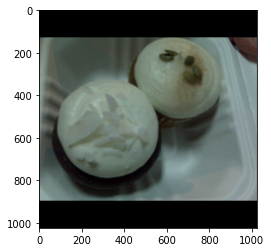

In [11]:
plt.imshow(image)

In [12]:
# Ground truth class id(s)
gt_class_id

array([3, 3])

In [13]:
results = model.detect([image], verbose=1)

Processing 1 images
image                    shape: (1024, 1024, 3)       min:    0.00000  max:  186.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:   76.10000  float64
image_metas              shape: (1, 17)               min:    0.00000  max: 1024.00000  int32
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32


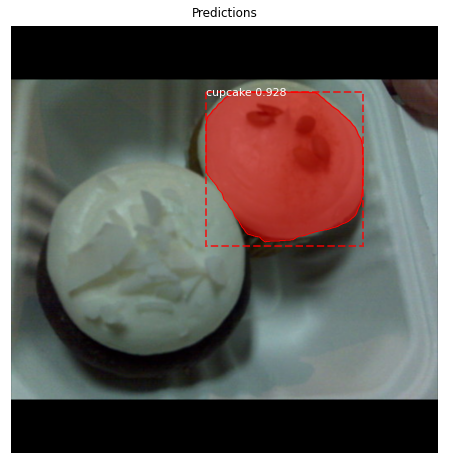

In [14]:
# Display results
ax = get_ax(1)
r = results[0]

visualize.display_instances(
    image,
    r['rois'],
    r['masks'],
    r['class_ids'],
    dataset.class_names,
    r['scores'],
    ax=ax,
    title="Predictions"
)

In [15]:
dataset.image_ids

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
       51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67,
       68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79])

In [16]:
d1 = {1: 2, 3: 3, 2: 4}
d2 = {4: 2}

In [26]:
# Calculate confusion matrix for a given class

def get_CM(CLASS_ID):
    cm = [[ 0, 0 ], [ 0, 0 ]]
    
    # cm[0][0] => actual true pred true
    # cm[0][1] => actual true pred false
    
    for i in range(len(dataset.image_ids)):
        image, _, gt_class_id, _, _ = modellib.load_image_gt(dataset, config, dataset.image_ids[i], use_mini_mask=False)

        results = model.detect([image], verbose=1)

        pred_class_id = results[0]['class_ids']

        d_gt = {}
        if CLASS_ID in gt_class_id:
            d_gt[1] = list(gt_class_id).count(CLASS_ID)
        else:
            d_gt[1] = 0
        d_gt[0] = len(gt_class_id) - d_gt[1]
        
        d_pred = {}
        if CLASS_ID in pred_class_id:
            d_pred[1] = list(pred_class_id).count(CLASS_ID)
        else:
            d_pred[1] = 0
        d_pred[0] = len(pred_class_id) - d_pred[1]
        
        truth = min(d_gt[1], d_pred[1])
        falsy = min(d_gt[0], d_pred[0])
        
        cm[0][0] += truth
        cm[1][1] += falsy
        
        d_gt[1] -= truth
        d_pred[1] -= truth
        
        d_gt[0] -= falsy
        d_pred[0] -= falsy
        
        if d_gt[1] > 0:
            cm[0][1] += d_gt[1]
        
        if d_pred[1] > 0:
            cm[1][0] += d_pred[1]
        
        print(f'DONE: {i+1}/{len(dataset.image_ids)}')

    return cm

In [27]:
cm_cupcake = get_CM(3)

Processing 1 images
image                    shape: (1024, 1024, 3)       min:    0.00000  max:  253.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  149.10000  float64
image_metas              shape: (1, 17)               min:    0.00000  max: 1024.00000  int32
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32
DONE: 1/80
Processing 1 images
image                    shape: (1024, 1024, 3)       min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  131.30000  float64
image_metas              shape: (1, 17)               min:    0.00000  max: 1024.00000  int32
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32
DONE: 2/80
Processing 1 images
image                    shape: (1024, 1024, 3)       min:    0.00000  max:  211.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.

DONE: 20/80
Processing 1 images
image                    shape: (1024, 1024, 3)       min:    0.00000  max:  254.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  150.10000  float64
image_metas              shape: (1, 17)               min:    0.00000  max: 1024.00000  int32
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32
DONE: 21/80
Processing 1 images
image                    shape: (1024, 1024, 3)       min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 17)               min:    0.00000  max: 1024.00000  int32
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32
DONE: 22/80
Processing 1 images
image                    shape: (1024, 1024, 3)       min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)

DONE: 40/80
Processing 1 images
image                    shape: (1024, 1024, 3)       min:    0.00000  max:  244.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  120.30000  float64
image_metas              shape: (1, 17)               min:    0.00000  max: 1024.00000  int32
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32
DONE: 41/80
Processing 1 images
image                    shape: (1024, 1024, 3)       min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 17)               min:    0.00000  max: 1024.00000  int32
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32
DONE: 42/80
Processing 1 images
image                    shape: (1024, 1024, 3)       min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)

DONE: 60/80
Processing 1 images
image                    shape: (1024, 1024, 3)       min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  145.10000  float64
image_metas              shape: (1, 17)               min:    0.00000  max: 1024.00000  int32
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32
DONE: 61/80
Processing 1 images
image                    shape: (1024, 1024, 3)       min:    0.00000  max:  254.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  150.10000  float64
image_metas              shape: (1, 17)               min:    0.00000  max: 1024.00000  int32
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32
DONE: 62/80
Processing 1 images
image                    shape: (1024, 1024, 3)       min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)

DONE: 80/80


In [28]:
cm_cupcake

[[24, 3], [0, 67]]

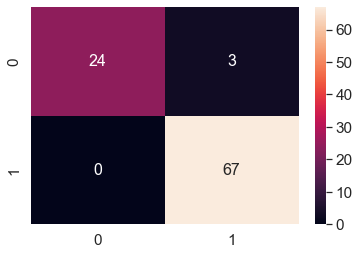

In [37]:
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt


df_cm = pd.DataFrame(cm_cupcake, range(2), range(2))
sn.set(font_scale=1.4) # for label size
sn.heatmap(df_cm, annot=True, annot_kws={"size": 16}) # font size

plt.show()